 # WOFOST Implementation Example for Fields of the World

 © 2021 Agrimetrics

 [Fields of the World](https://app.agrimetrics.co.uk/catalog/data-sets/ae7ea6be-9731-46fc-9e01-ca71a8aca871/overview) is an Open Access dataset created by Agrimetrics and supported by Microsoft's [AI for Earth](https://www.microsoft.com/en-gb/ai/ai-for-earth) programme.
 These Jupyter notebooks walk you through running a WOFOST simulation using Fields of the World data.
 WOFOST is a crop growth and production simulation model for annual field crops, developed at Wageningen University and Research (de Wit *et al.* 2019).
 WOFOST simulates crop growth that is then used to predict crop development over time and crop yields.
 Specifically, this notebook will run a WOFOST simulation on multiple fields in the UK, France and The Netherlands; comparing total weight of storage organs yields using weather and soil data from the [Fields of the World](https://app.agrimetrics.co.uk/catalog/data-sets/ae7ea6be-9731-46fc-9e01-ca71a8aca871/overview) dataset.


 Here we are using a Python package [PCSE (Python Crop Simulation Environment)](https://pcse.readthedocs.io/en/stable/), which can implement various WOFOST models.

 Running PCSE/WOFOST on custom input data then requires 3 key things:

 1. Parameter values for different components of the WOFOST model; specifically those representing the crop and soil.
 2. Driving variables representing changing environmental conditions, specifically weather here.
 3. Agromanagement actions that specify farm activities that will take place on the field that is simulated by PCSE.


 These are all set up as part of the scripts below.

 ## 1. Import required libraries

 The first step is to install the various libraries that we need. This includes a number of modules from PCSE.

In [1]:
import sys
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pcse
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLCropDataProvider
from pcse.models import Wofost71_WLP_FD
from pcse.util import WOFOST71SiteDataProvider

import import_ipynb
from agri_wofost import agri_wofost_soil_data, agri_wofost_management_data, agri_wofost_weather_data, field_ids

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" % pcse.__version__)


importing Jupyter notebook from agri_wofost.ipynb
importing Jupyter notebook from agri_graphql.ipynb
This notebook was built with:
python version: 3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110] 
PCSE version: 5.4.2


 ## 2. Define the French, UK and Netherlands fields
 We next define the fields using a sowncrop dataset id and a region of interest polygon for each each country.

In [2]:
fotw_dataset_id = "https://data.agrimetrics.co.uk/data-sets/ae7ea6be-9731-46fc-9e01-ca71a8aca871"

fr = {
    "country": "FR",
    "sowncrop_dataset_id": "https://data.agrimetrics.co.uk/data-sets/200b3b0b-f1f4-4beb-8428-cfee7524bd57",
    "roi": [
        [
            [2.862061, 45.595366],
            [2.862061, 46.211191],
            [4.284017, 46.211191],
            [4.284017, 45.595366],
            [2.862061, 45.595366],
        ]
    ],
}

uk = {
    "country": "UK",
    "sowncrop_dataset_id": "https://data.agrimetrics.co.uk/data-sets/9094d9f1-8fdf-4a86-9b0a-ce6f62887822",
    "roi": [
        [
            [-9.448242, 49.441095],
            [-9.448242, 58.239827],
            [2.8125, 58.239827],
            [2.8125, 49.441095],
            [-9.448242, 49.441095],
        ]
    ],
}

nl = {
    "country": "NL",
    "sowncrop_dataset_id": "https://data.agrimetrics.co.uk/data-sets/4155d810-5f0f-406d-a4a7-37ac8cb05880",
    "roi": [[[3.7, 51.5], [3.7, 51.6], [3.8, 51.6], [3.8, 51.5], [3.7, 51.5]]],
}

wheat_datasets = {"France": fr, "United Kingdom": uk, "Netherlands": nl}


 ## 3. Retrieve Agrimetrics field identifiers
 Obtain field identifiers by running GraphQL queries and filtering the results for ids pertaining to wheat fields.

In [3]:
for dataset in wheat_datasets.values():
    fields = field_ids(dataset["roi"], fotw_dataset_id, dataset["sowncrop_dataset_id"])
    fields = fields[fields["crop"] == "WHEAT"]
    dataset["fields"] = fields


 ## 4. Selecting crop specific parameters

 To access WOFOST crop parameter files we use the `YAMLCropDataProvider()` to pull YAML files from the package's [GitHub](https://github.com/ajwdewit/WOFOST_crop_parameters) repository.

 Our crop and variety of interest is then activated (Winter_wheat_102 for southern UK).

 See also PCSE [Quickstart](https://pcse.readthedocs.io/en/stable/quickstart.html#an-interactive-pcse-wofost-session) for further documentation.

In [4]:
crop_data = YAMLCropDataProvider()
crop_data.set_active_crop("wheat", "Winter_wheat_102")


 ## 5. Define site parameters
 We next define parameters specific to the site. We largely use default parameter values for simplicity, however we need to set the `CO2` argument set to the global average atmospheric carbon dioxide level (ppm) as at 2019 ([Lindsey, R. 2020](https://www.climate.gov/news-features/understanding-climate/climate-change-atmospheric-carbon-dioxide)).

In [5]:
site_data = WOFOST71SiteDataProvider(WAV=100, CO2=409.8)  # 2019


 ## 6. Run WOFOST simulation to calculate yields on all fields for 2017-20

 Simulations for some UK fields will not be available. This is due to lack of coverage of interpolated weather data in the ECMWF data near the coastline.
 Running these simulations can take approximately 50 minutes.

In [6]:
def wofost_yields(fields, country):
    print(f"Simulating yields for {country}")
    for _, (field_id, year) in fields[["id", "year"]].iterrows():

        try:
            soil_data = agri_wofost_soil_data(field_id, country)
            parameters = ParameterProvider(cropdata=crop_data, soildata=soil_data, sitedata=site_data)
        except Exception as e:
            print(f"Failed to get soil data data for {field_id}: {e}")
            continue

        try:
            agromanagement = agri_wofost_management_data(field_id, year)
        except Exception as e:
            print(f"Failed to get agromanagement data for {field_id}: {e}")
            continue

        try:
            wdp = agri_wofost_weather_data(field_id, f"{year-1}-04-01", f"{year}-08-31")
        except Exception as e:
            print(f"Failed to get weather data for {field_id}: {e}")
            continue

        try:
            wofost_sim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
            wofost_sim.run_till_terminate()
            wofost_output = wofost_sim.get_output()

            wofost_yield = wofost_output[-1]["TWSO"]

            yield {
                "country": country,
                "field_id": field_id,
                "year": year,
                "yield": wofost_yield,
            }

        except Exception as e:
            print(f"Failed simulation for {field_id}: {e}")
            continue


t1 = time()
yields = pd.DataFrame(
    simulated_yield
    for dataset in wheat_datasets.values()
    for simulated_yield in wofost_yields(dataset["fields"], dataset["country"])
)
t2 = time()
print(f"Time elapsed: {(t2-t1)/60} minutes")

Simulating yields for FR
Simulating yields for UK
Failed to get soil data data for https://data.agrimetrics.co.uk/fields/-2UcCtUjrLDtK2ZV8DWz0A: 'NoneType' object is not subscriptable
Failed to get soil data data for https://data.agrimetrics.co.uk/fields/-2UcCtUjrLDtK2ZV8DWz0A: 'NoneType' object is not subscriptable
Failed to get soil data data for https://data.agrimetrics.co.uk/fields/-SU7_vUOL1eXsALqgxhR9Q: 'NoneType' object is not subscriptable
Failed to get soil data data for https://data.agrimetrics.co.uk/fields/-SU7_vUOL1eXsALqgxhR9Q: 'NoneType' object is not subscriptable
Failed to get soil data data for https://data.agrimetrics.co.uk/fields/-XaVU1nN4gmWFNKVRnkecg: 'NoneType' object is not subscriptable
Failed to get weather data for https://data.agrimetrics.co.uk/fields/1CRdQMvOHzL2eD1AnZdU6A: 'NoneType' object is not iterable
Failed to get soil data data for https://data.agrimetrics.co.uk/fields/1UkY7lpZ3H0PPlifIZ6utQ: 'NoneType' object is not subscriptable
Failed to get weath

 ## 7. Results
 This notebook (and additional helper modules) show how a WOFOST simulation can be run for multiple fields using weather and soil data from Agrimetrics APIs.
 For illustrative purposes, we show here some results from the simulations.
 The plots show mean yields (TWSO - Total dry weight of storage organs)(kg ha$^{-1}$) of the UK, France and The Netherlands between 2017 and 2020.

 There is some variation to be seen between years within the UK. With a similarity between the UK and France for 2017.
 For 2018, The Netherlands have greater mean yields than the UK.

 Confidence intervals are one Standard Deviation.

Text(0, 0.5, 'Average Yield (kg $\\rm{ha^{-1}}$)')

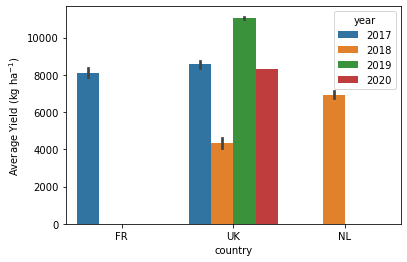

In [7]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=yields, x="country", y="yield", hue="year", ci="sd")
ax.set_ylabel("Average Yield (kg $\\rm{ha^{-1}}$)")


# References

 de Wit, Allard, Hendrik Boogaard, Davide Fumagalli, Sander Janssen, Rob Knapen, Daniel van Kraalingen, Iwan Supit, Raymond van der Wijngaart, and Kees van Diepen. "25 years of the WOFOST cropping systems model." Agricultural Systems 168 (2019): 154-167.